### Выбранные стили: y2k vs classic

### 1. Сбор небольшого датасета

По 20 изображений каждого стиля сохранениы в папках `train` и `val` в соответствующих директориях

### 2. Мини-анализ стилей

   **y2k**: яркий, броский, насыщенный стиль, характерный для моды конца 90-х – начала 2000-х. Он отличается обилием блестящих материалов, металлизированных поверхностей, трикотажа с эластичностью, количеством открытых элементов, низкой посадкой брюк, обилием аксессуаров и насыщенной цветовой палитрой. Силуэты часто акцентирующие фигуру как засчет только приталенности, так и засчет сочетания ее с объемными вещам. Текстуры включают глянец, деним, кожу, меховые детали и принты. Обувь часто на высоком тонком каблуке или же акцентная спортивная. Характерен для тинейджеров.
   
   **classic**: характерны минимализм и структурированность, актуальность сквозь года. Этот стиль использует качественные натуральные материалы: шерсть, хлопок, кашемир, кожу. А также нейтральные и приглушённые цвета: чёрный, белый, бежевый, тёмно-синий. Силуэты чаще прямые, строгие и симметричные: пиджаки, брюки со стрелками, гладкие платья, пальто. Текстуры матовые, без лишнего декора, с чистыми линиями и чёткой посадкой. Количество аксессуаров минимально. Обувь зачастую из кожи на сдержанном каблуке. Может быть присущ людям всех возрастов.

   потенциальные признаки:
   - **цветовая гамма**: яркие/металлизированные оттенки vs нейтральные/базовые
   - **текстуры**: блеск и синтетика vs матовые натуральные материалы
   - **силуэты**: обтягивающие мини-силуэты vs строгие прямые линии
   - **детали**: y2k — декоративные элементы, обилие аксессуаров; classic — отсутствие декора, минимализм
   - **контраст на изображении**: y2k чаще имеет броские акценты и насыщенные участки
   - **обувь**: преобладают яркие, глянцевые и массивные модели vs нейтральная, минималистичная и строгая обувь
   - **возраст**: стиль y2k чаще встречается у подростков и молодых людей, classic встречается у всех

### 3. Обучение небольшой модели

In [1]:
import pandas as pd
import numpy as np
import requests
import math
from io import BytesIO
import matplotlib.pylab as plt
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision import models, datasets
import torch
import torch.nn as nn
from PIL import Image, ImageFilter
import seaborn as sns
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, ConcatDataset, Subset

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
pipeline1 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05),
    transforms.ToTensor(),
    normalize
])

pipeline2 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=1.0),
    transforms.ToTensor(),
    normalize
])

pipeline3 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.GaussianBlur(radius=1))),
    transforms.ToTensor(),
    normalize
])

pipeline4 = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.02),
    transforms.ToTensor(),
    normalize
])

In [4]:
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [5]:
train_original = datasets.ImageFolder("data/train", transform=val_transforms)
train_aug1 = datasets.ImageFolder("data/train", transform=pipeline1)
train_aug2 = datasets.ImageFolder("data/train", transform=pipeline2)
train_aug3 = datasets.ImageFolder("data/train", transform=pipeline3)
train_aug4 = datasets.ImageFolder("data/train", transform=pipeline4)

train_dataset = ConcatDataset([train_original, train_aug1, train_aug2, train_aug3, train_aug4])
val_dataset   = datasets.ImageFolder("data/val",   transform=val_transforms)

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device(
        "mps" if torch.backends.mps.is_available()
        else "cuda" if torch.cuda.is_available()
        else "cpu"
    )

    model.to(device)

    train_losses, val_losses = [], []
    train_accuracy, val_accuracy = [], []
    train_f1, val_f1 = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        y_true_train, y_pred_train = [], []

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = running_corrects.float() / len(train_loader.dataset)
        train_f1_epoch = f1_score(y_true_train, y_pred_train, average="macro")

        model.eval()
        running_loss = 0.0
        running_corrects = 0

        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = running_corrects.float() / len(val_loader.dataset)
        val_f1_epoch = f1_score(y_true_val, y_pred_val, average="macro")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracy.append(train_acc.item())
        val_accuracy.append(val_acc.item())
        train_f1.append(train_f1_epoch)
        val_f1.append(val_f1_epoch)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"train loss: {train_loss:.4f}, acc: {train_acc:.4f}, f1: {train_f1_epoch:.4f} | "
            f"val loss: {val_loss:.4f}, acc: {val_acc:.4f}, f1: {val_f1_epoch:.4f}"
        )

    return (
        train_losses, val_losses,
        train_accuracy, val_accuracy,
        train_f1, val_f1
    )


In [7]:
def train_kfold(model_class, dataset, k_splits, criterion, optimizer_fn,
                batch_size, num_epochs):

    targets = [dataset[i][1] for i in range(len(dataset))]
    skf = StratifiedKFold(n_splits=k_splits, shuffle=True, random_state=42)

    all_fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(range(len(dataset)), targets), 1):
        print(f"\nFold {fold_idx}/{k_splits}")

        train_subset = Subset(dataset, train_idx)
        val_subset   = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

        model = model_class()
        optimizer = optimizer_fn(model)

        (
            train_loss, val_loss,
            train_acc, val_acc,
            train_f1, val_f1
        ) = train(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            num_epochs
        )

        all_fold_results.append({
            "fold": fold_idx,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc,
            "train_f1": train_f1,
            "val_f1": val_f1,
            "model": model,
        })

    return all_fold_results

In [8]:
def make_optimizer(model):
    return torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)

    def forward(self, x):
        return self.model(x)

In [10]:
full_dataset = ConcatDataset([train_original, train_aug1, train_aug2, train_aug3, train_aug4])

In [11]:
criterion = torch.nn.CrossEntropyLoss()

### 4. Результаты

In [12]:
results = train_kfold(
    model_class=MyModel,
    dataset=full_dataset,
    k_splits=5,
    criterion=criterion,
    optimizer_fn=make_optimizer,
    batch_size=16,
    num_epochs=10
)


Fold 1/5


/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] train loss: 0.4557, acc: 0.7750, f1: 0.7742 | val loss: 0.1113, acc: 1.0000, f1: 1.0000
Epoch [2/10] train loss: 0.0757, acc: 0.9917, f1: 0.9917 | val loss: 0.0222, acc: 1.0000, f1: 1.0000
Epoch [3/10] train loss: 0.0205, acc: 1.0000, f1: 1.0000 | val loss: 0.0127, acc: 1.0000, f1: 1.0000
Epoch [4/10] train loss: 0.0159, acc: 1.0000, f1: 1.0000 | val loss: 0.0052, acc: 1.0000, f1: 1.0000
Epoch [5/10] train loss: 0.0305, acc: 0.9917, f1: 0.9917 | val loss: 0.0048, acc: 1.0000, f1: 1.0000
Epoch [6/10] train loss: 0.0101, acc: 1.0000, f1: 1.0000 | val loss: 0.0072, acc: 1.0000, f1: 1.0000
Epoch [7/10] train loss: 0.0472, acc: 0.9833, f1: 0.9833 | val loss: 0.0067, acc: 1.0000, f1: 1.0000
Epoch [8/10] train loss: 0.1119, acc: 0.9750, f1: 0.9750 | val loss: 0.0054, acc: 1.0000, f1: 1.0000
Epoch [9/10] train loss: 0.0047, acc: 1.0000, f1: 1.0000 | val loss: 0.0149, acc: 1.0000, f1: 1.0000
Epoch [10/10] train loss: 0.0196, acc: 1.0000, f1: 1.0000 | val loss: 0.0537, acc: 0.9667, 

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] train loss: 0.4821, acc: 0.7417, f1: 0.7402 | val loss: 0.2003, acc: 0.9333, f1: 0.9330
Epoch [2/10] train loss: 0.0451, acc: 1.0000, f1: 1.0000 | val loss: 0.0555, acc: 0.9667, f1: 0.9666
Epoch [3/10] train loss: 0.0244, acc: 1.0000, f1: 1.0000 | val loss: 0.0250, acc: 1.0000, f1: 1.0000
Epoch [4/10] train loss: 0.0064, acc: 1.0000, f1: 1.0000 | val loss: 0.0377, acc: 0.9667, f1: 0.9666
Epoch [5/10] train loss: 0.0117, acc: 1.0000, f1: 1.0000 | val loss: 0.0308, acc: 0.9667, f1: 0.9666
Epoch [6/10] train loss: 0.0053, acc: 1.0000, f1: 1.0000 | val loss: 0.0104, acc: 1.0000, f1: 1.0000
Epoch [7/10] train loss: 0.0151, acc: 0.9917, f1: 0.9917 | val loss: 0.0182, acc: 1.0000, f1: 1.0000
Epoch [8/10] train loss: 0.0084, acc: 1.0000, f1: 1.0000 | val loss: 0.0167, acc: 1.0000, f1: 1.0000
Epoch [9/10] train loss: 0.0020, acc: 1.0000, f1: 1.0000 | val loss: 0.0113, acc: 1.0000, f1: 1.0000
Epoch [10/10] train loss: 0.0150, acc: 0.9917, f1: 0.9917 | val loss: 0.1145, acc: 0.9667, 

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] train loss: 0.4367, acc: 0.7750, f1: 0.7664 | val loss: 0.1934, acc: 0.9667, f1: 0.9666
Epoch [2/10] train loss: 0.0381, acc: 0.9917, f1: 0.9917 | val loss: 0.0501, acc: 0.9667, f1: 0.9666
Epoch [3/10] train loss: 0.0220, acc: 1.0000, f1: 1.0000 | val loss: 0.0346, acc: 1.0000, f1: 1.0000
Epoch [4/10] train loss: 0.0031, acc: 1.0000, f1: 1.0000 | val loss: 0.0171, acc: 1.0000, f1: 1.0000
Epoch [5/10] train loss: 0.0078, acc: 1.0000, f1: 1.0000 | val loss: 0.0366, acc: 0.9667, f1: 0.9666
Epoch [6/10] train loss: 0.0058, acc: 1.0000, f1: 1.0000 | val loss: 0.0332, acc: 1.0000, f1: 1.0000
Epoch [7/10] train loss: 0.0036, acc: 1.0000, f1: 1.0000 | val loss: 0.0154, acc: 1.0000, f1: 1.0000
Epoch [8/10] train loss: 0.0031, acc: 1.0000, f1: 1.0000 | val loss: 0.0486, acc: 0.9667, f1: 0.9666
Epoch [9/10] train loss: 0.0030, acc: 1.0000, f1: 1.0000 | val loss: 0.0145, acc: 1.0000, f1: 1.0000
Epoch [10/10] train loss: 0.0041, acc: 1.0000, f1: 1.0000 | val loss: 0.0096, acc: 1.0000, 

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] train loss: 0.3842, acc: 0.8000, f1: 0.7954 | val loss: 0.1135, acc: 0.9667, f1: 0.9666
Epoch [2/10] train loss: 0.0528, acc: 0.9833, f1: 0.9833 | val loss: 0.0143, acc: 1.0000, f1: 1.0000
Epoch [3/10] train loss: 0.0170, acc: 1.0000, f1: 1.0000 | val loss: 0.0064, acc: 1.0000, f1: 1.0000
Epoch [4/10] train loss: 0.0052, acc: 1.0000, f1: 1.0000 | val loss: 0.0072, acc: 1.0000, f1: 1.0000
Epoch [5/10] train loss: 0.0113, acc: 1.0000, f1: 1.0000 | val loss: 0.0030, acc: 1.0000, f1: 1.0000
Epoch [6/10] train loss: 0.0016, acc: 1.0000, f1: 1.0000 | val loss: 0.0292, acc: 0.9667, f1: 0.9666
Epoch [7/10] train loss: 0.0022, acc: 1.0000, f1: 1.0000 | val loss: 0.0026, acc: 1.0000, f1: 1.0000
Epoch [8/10] train loss: 0.0018, acc: 1.0000, f1: 1.0000 | val loss: 0.0083, acc: 1.0000, f1: 1.0000
Epoch [9/10] train loss: 0.0013, acc: 1.0000, f1: 1.0000 | val loss: 0.0018, acc: 1.0000, f1: 1.0000
Epoch [10/10] train loss: 0.0027, acc: 1.0000, f1: 1.0000 | val loss: 0.0017, acc: 1.0000, 

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10] train loss: 0.3998, acc: 0.8333, f1: 0.8303 | val loss: 0.1002, acc: 0.9667, f1: 0.9666
Epoch [2/10] train loss: 0.0379, acc: 1.0000, f1: 1.0000 | val loss: 0.0158, acc: 1.0000, f1: 1.0000
Epoch [3/10] train loss: 0.0102, acc: 1.0000, f1: 1.0000 | val loss: 0.0068, acc: 1.0000, f1: 1.0000
Epoch [4/10] train loss: 0.0070, acc: 1.0000, f1: 1.0000 | val loss: 0.0039, acc: 1.0000, f1: 1.0000
Epoch [5/10] train loss: 0.0233, acc: 0.9833, f1: 0.9833 | val loss: 0.0016, acc: 1.0000, f1: 1.0000
Epoch [6/10] train loss: 0.0023, acc: 1.0000, f1: 1.0000 | val loss: 0.0009, acc: 1.0000, f1: 1.0000
Epoch [7/10] train loss: 0.0173, acc: 0.9917, f1: 0.9917 | val loss: 0.0013, acc: 1.0000, f1: 1.0000
Epoch [8/10] train loss: 0.0061, acc: 1.0000, f1: 1.0000 | val loss: 0.0010, acc: 1.0000, f1: 1.0000
Epoch [9/10] train loss: 0.0036, acc: 1.0000, f1: 1.0000 | val loss: 0.0011, acc: 1.0000, f1: 1.0000
Epoch [10/10] train loss: 0.0024, acc: 1.0000, f1: 1.0000 | val loss: 0.0008, acc: 1.0000, 

In [13]:
def plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    train_f1,
    val_f1,
    title=None
):
    if isinstance(train_losses[0], (list, np.ndarray)):
        train_losses = np.mean(train_losses, axis=0)
        val_losses   = np.mean(val_losses, axis=0)
        train_acc    = np.mean(train_acc, axis=0)
        val_acc      = np.mean(val_acc, axis=0)
        train_f1     = np.mean(train_f1, axis=0)
        val_f1       = np.mean(val_f1, axis=0)

    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(epochs, train_losses, label="Train", linewidth=2)
    axes[0].plot(epochs, val_losses, label="Validation", linewidth=2)
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(epochs, train_acc, label="Train", linewidth=2)
    axes[1].plot(epochs, val_acc, label="Validation", linewidth=2)
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    axes[2].plot(epochs, train_f1, label="Train", linewidth=2)
    axes[2].plot(epochs, val_f1, label="Validation", linewidth=2)
    axes[2].set_title("F1-score (macro)")
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("F1")
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    if title:
        fig.suptitle(title, fontsize=14)

    plt.tight_layout()
    plt.show()


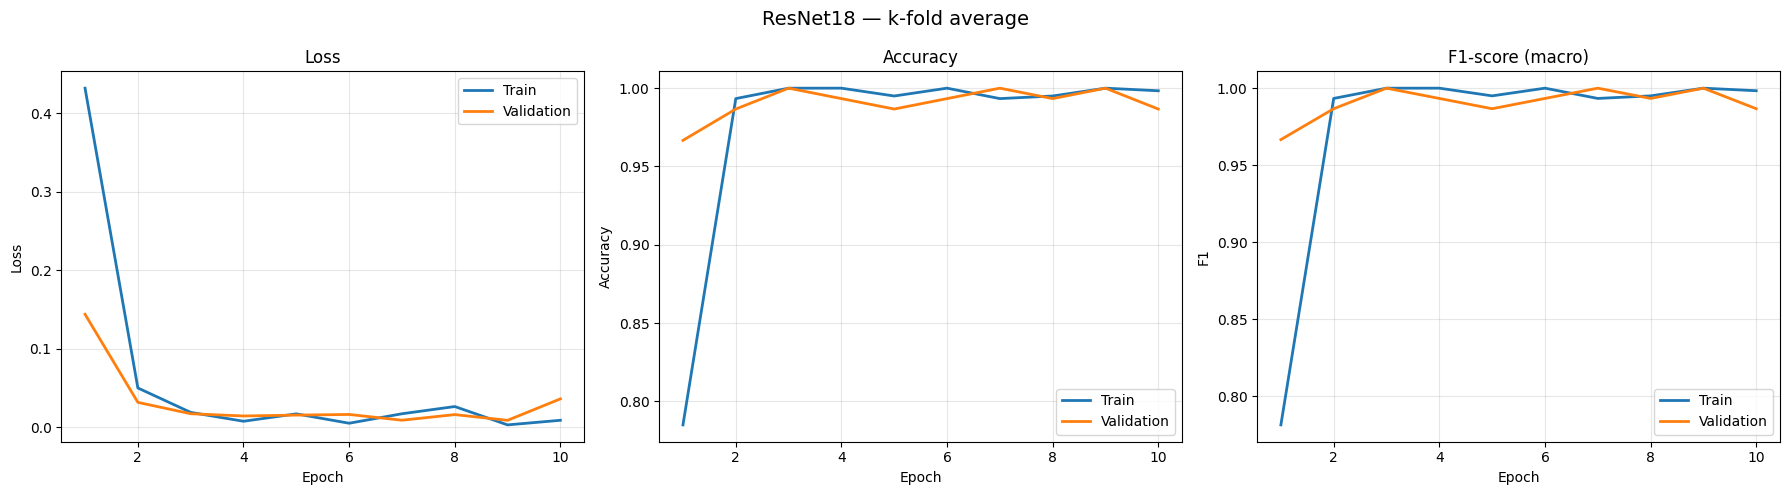

In [14]:
train_losses = [r["train_loss"] for r in results]
val_losses   = [r["val_loss"]   for r in results]
train_acc    = [r["train_acc"]  for r in results]
val_acc      = [r["val_acc"]    for r in results]
train_f1    = [r["train_f1"]  for r in results]
val_f1      = [r["val_f1"]    for r in results]

plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    train_f1,
    val_f1,
    title="ResNet18 — k-fold average"
)

In [15]:
clipped_results = []
for res in results:
    clipped_results.append({
            "fold": res['fold'],
            "train_loss": res['train_loss'][:5],
            "val_loss": res['val_loss'][:5],
            "train_acc": res['train_acc'][:5],
            "val_acc": res['val_acc'][:5],
            "train_f1": res['train_f1'][:5],
            "val_f1": res['val_f1'][:5]
        })

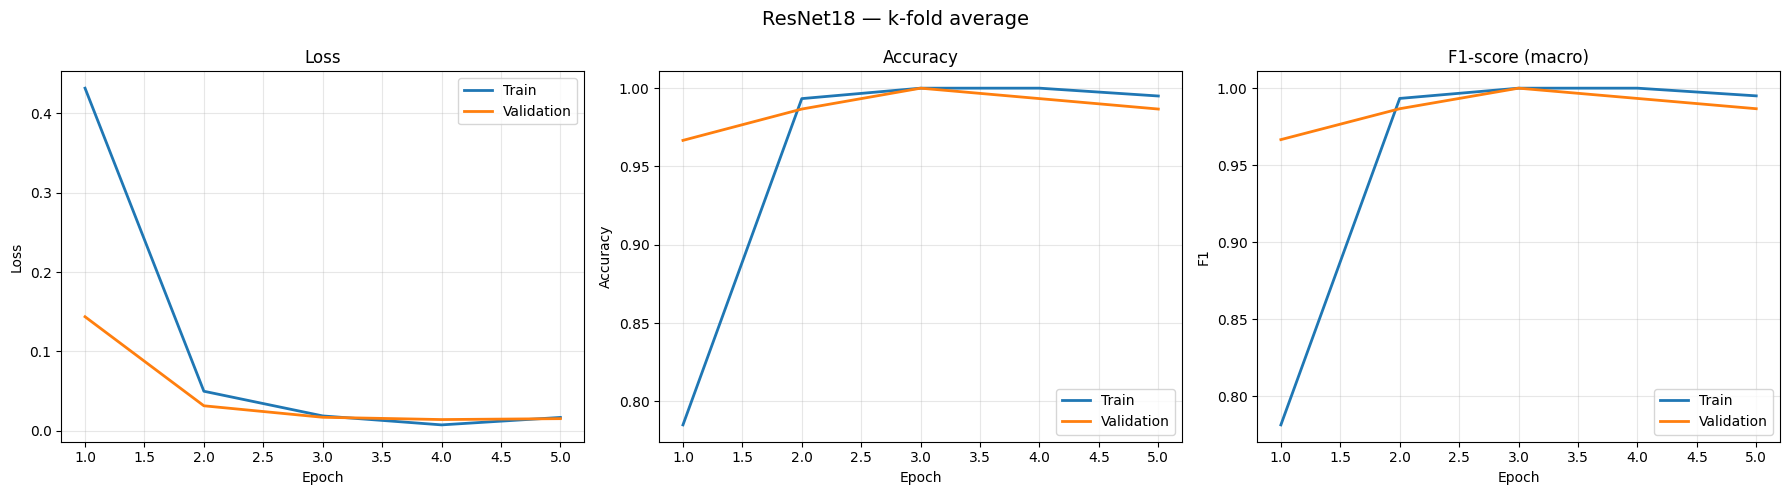

In [16]:
train_losses = [r["train_loss"] for r in clipped_results]
val_losses   = [r["val_loss"]   for r in clipped_results]
train_acc    = [r["train_acc"]  for r in clipped_results]
val_acc      = [r["val_acc"]    for r in clipped_results]
train_f1    = [r["train_f1"]  for r in clipped_results]
val_f1      = [r["val_f1"]    for r in clipped_results]

plot_training_results(
    train_losses,
    val_losses,
    train_acc,
    val_acc,
    train_f1,
    val_f1,
    title="ResNet18 — k-fold average"
)

In [17]:
final_model = results[-1]['model']

In [18]:
torch.save(final_model.state_dict(), "final_resnet_y2k_vs_classic.pth")

In [19]:
final_model = MyModel()
final_model.load_state_dict(torch.load("final_resnet_y2k_vs_classic.pth"))
final_model.eval()

/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/vlanuka/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MyModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [20]:
def predict_image(model, image, transform, class_names):
    model.eval()

    x = transform(image).unsqueeze(0)  

    with torch.no_grad():
        logits = model(x)
        probs = F.softmax(logits, dim=1)

    pred_idx = torch.argmax(probs, dim=1).item()
    confidence = probs[0, pred_idx].item()

    return class_names[pred_idx], confidence

In [21]:
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    return img

In [22]:
def show_images_grid(images, titles, cols=3, figsize=(15, 10)):
    rows = math.ceil(len(images) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")

    for ax in axes[len(images):]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

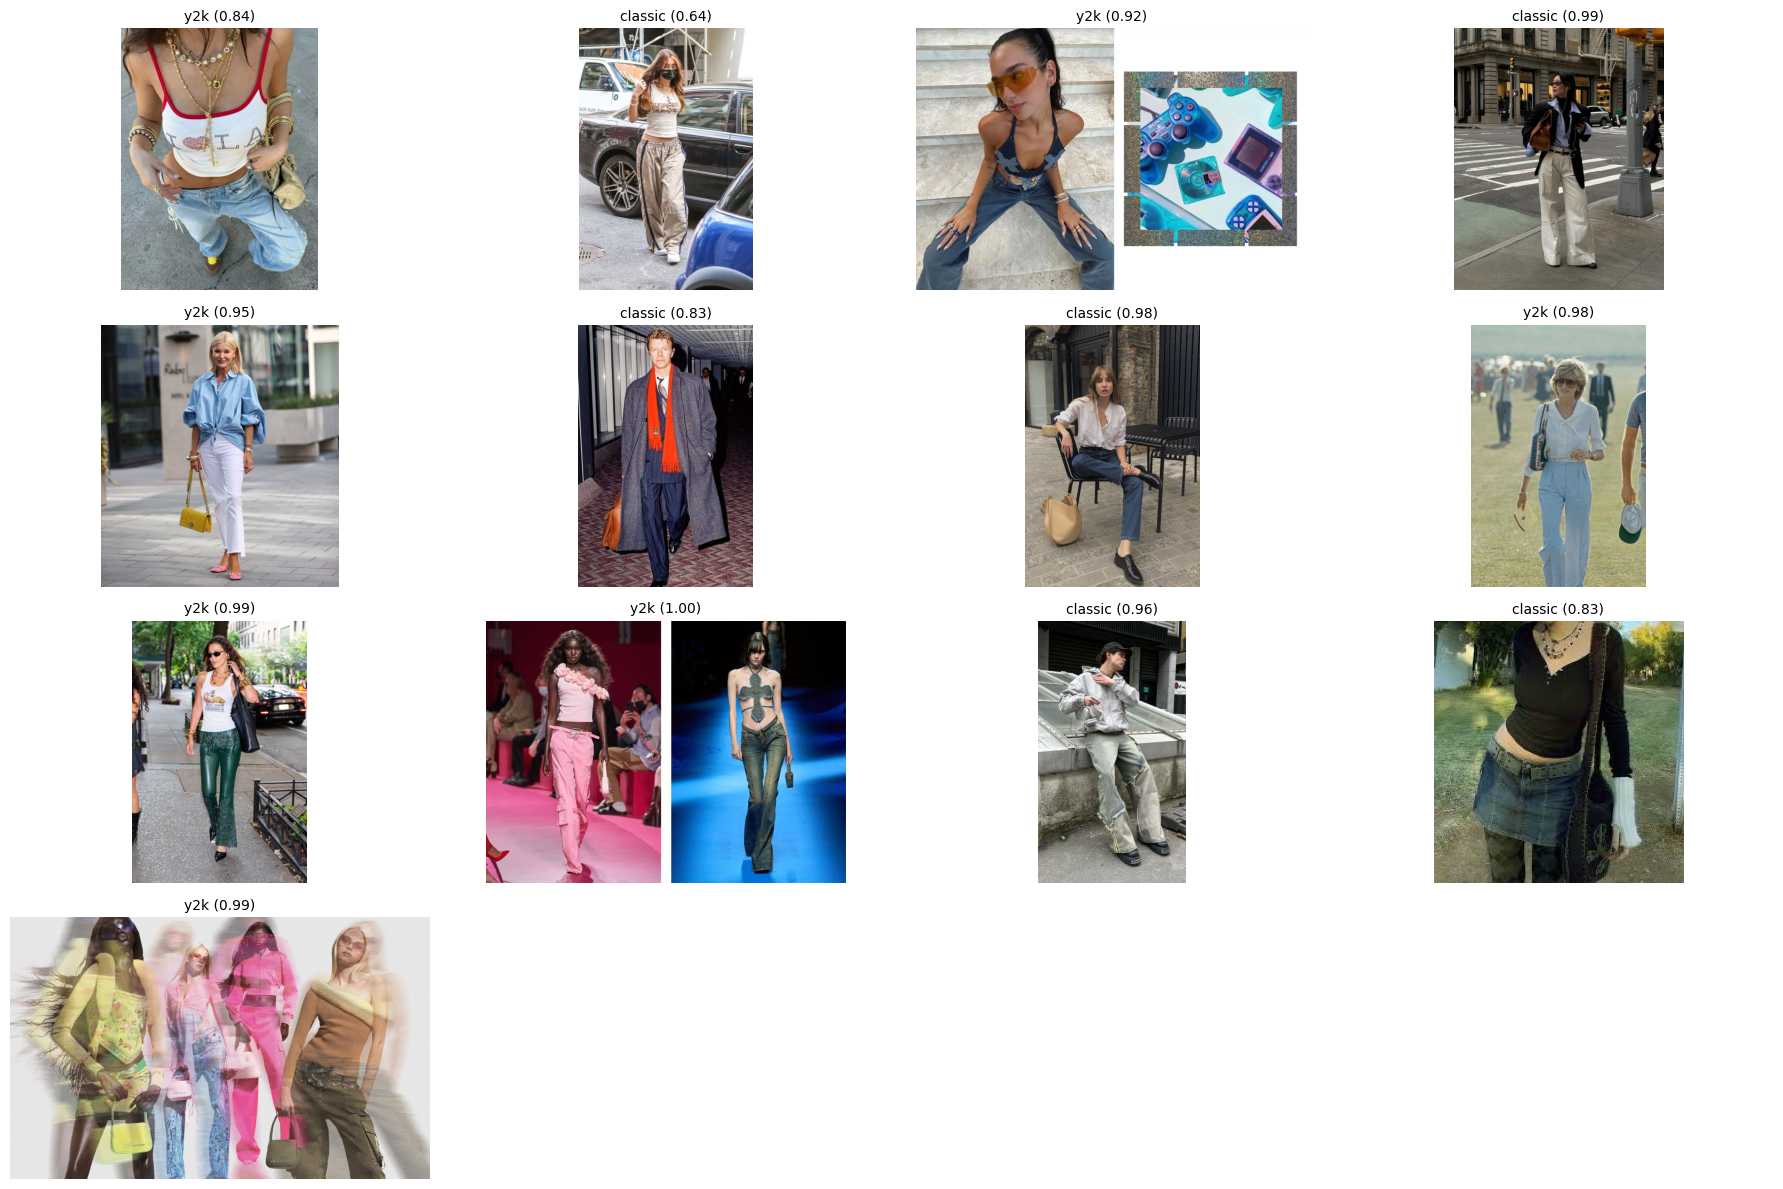

In [23]:
urls = ["https://jonathanfrips.com/wp-content/uploads/2025/02/1-1.jpeg",
      'https://us.modalova.com/zine/wp-content/uploads/2022/07/tendance-normcore-2022.jpg',
      'https://michael-kors.com.ru/image/conver_to_webp/catalog/blog/y2k/image_2023-12-26_16-26-13.webp',
      'https://cdn.mos.cms.futurecdn.net/XjdGvGxJLhSDNfiJ4Bxbo.jpg',
      'https://www.lieblingsstil.com/wp-content/uploads/2021/08/moderner-Classic-Style-SoSue-Bluse-Bluse-geknotet--scaled.jpg',
      'https://thevou.com/wp-content/uploads/2024/09/David-Bowie-Male-Fashion-Icon-Classic-Style.jpg',
       'https://i.pinimg.com/736x/3a/09/57/3a0957c713d8324011785f79befbc0fc.jpg',
       'https://i0.wp.com/sarah-tucker.com/wp-content/uploads/2024/04/3-1.png?fit=600%2C900&ssl=1',
       'https://assets.vogue.com/photos/678ac4a7e831a5e94ddc5394/master/w_2560%2Cc_limit/2161812386',
       'https://www.istitutomarangoni.com/marangoni/entities/magazinearticle/Y2K-CHINA-02.jpg',
       'https://i.pinimg.com/736x/2f/c6/e9/2fc6e9f1e223a153311e8926f1807fa1.jpg',
       'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRX4f9JhnURuEBR4YbUN4kxTKkWr5dm6XzWEg&s',
       'https://fashionmagazine.com/wp-content/uploads/2022/09/FEATURE_Y2KBody_1022.jpg']  

images = []
titles = []

for url in urls:
    image = load_image_from_url(url)

    label, conf = predict_image(
        model=final_model,
        image=image,
        transform=val_transforms,
        class_names=["classic", "y2k"]
    )

    images.append(image)
    titles.append(f"{label} ({conf:.2f})")

show_images_grid(
    images,
    titles,
    cols=4,   
    figsize=(18, 12)
)

### 5. Отчёт

**Как собирала данные?**
На Pinterest по одноименным запросам. Следила за тем, чтобы изображения были в том числе в пределах одного из стилей разнообразными: не только по одному человеку на фото, разные ракурсы (как в полный рост, така и более детальные фото без лица), разные фоны (однотонные и нагруженные деталями), качество фотографий (как и хорошо отфотканные, так и зашумленные и пересвеченные). 

**Как подготовили изображения?**
Изображения были разделены на обучающую и валидационную выборки в соотношении 15:5, при этом все изображения приведены к единому размеру 224×224 пикселя для совместимости с предобученными CNN-моделями. Для обучающей выборки применялись различные аугментации, включая горизонтальный flip, повороты, цветовые изменения, аффинные преобразования, перспективные искажения, размытие и усиление резкости, что позволило увеличить объём данных и разнообразие обучающих примеров. После аугментаций все изображения преобразовывались в тензоры и нормализовались с использованием средних и стандартных отклонений каналов ImageNet (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]). Изображения валидационной выборки не подвергались аугментациям и сохраняли исходный вид, за исключением изменения размера и нормализации.

**Какую модель выбрали и почему?**
Для классификации изображений был выбран **ResNet18**. Эта модель была выбрана из-за своей сбалансированной архитектуры: она достаточно компактная для работы с небольшими объемами данных, при этом обладает достаточной глубиной для извлечения признаков сложных изображений одежды. На начальных этапах также пробовала использовать MobileNet, но она уступала в показателях выбранной ResNet18.

**Основные параметры обучения:**
   
    - batch size = 16 
    - lr = 1e-4
    - количество эпох = 10

    с такой настройкой получаются примерно следующие показатели:
    train loss: 0.0024, acc: 1.0000, f1: 1.0000 | val loss: 0.0008, acc: 1.0000, f1: 1.0000
    

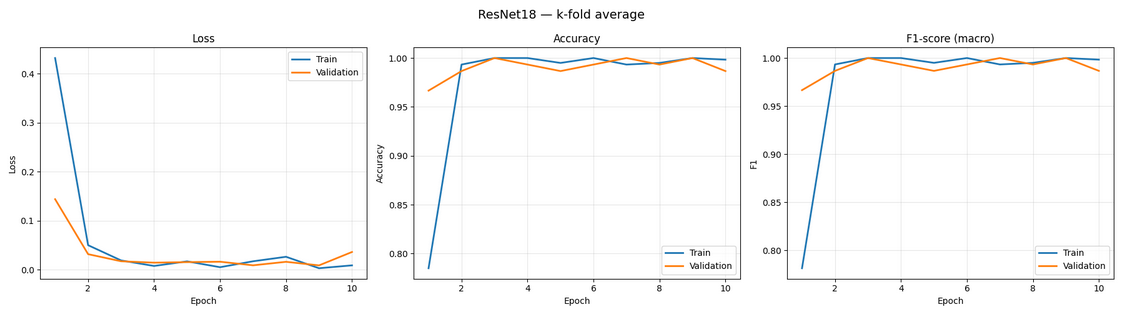

## Выводы

- Модель успешно обучается и демонстрирует **высокие значения accuracy и F1-score** на валидационных данных.
- После добавления **k-fold кросс-валидации** поведение метрик стало значительно стабильнее, так как до кросс-валидации метрики на валидационном множестве сильно колебались от эпохи к эпохе (пример на изображении снизу). А после её добавления метрики в процессе обучения **стали плавно расти и в целом оставались близкими к 1 на большинстве эпох**.
- С использованием **аугментаций** удалось существенно разнообразить датасет без ручного сбора новых данных

### Наблюдаемые ограничения модели

На этапе инференса финальной модели были выявлены характерные ошибки:
- **неконтрастные изображения** часто ошибочно классифицируются как *classic*;
- **классические приталенные аутфиты с яркими или нестандартными акцентами** модель может отнести к классу *y2k*.

Это указывает на то, что модель в значительной степени опирается на цветовую палитру фотографии.

### Возможные улучшения

- **Расширение датасета**: добавить больше изображений с пограничными случаями, увеличить разнообразие стилей, освещения и фонов, сбалансировать количество примеров сложных для классификации образов.
- Более тонкая настройка **аугментаций** (например, контраст/цвет отдельно для каждого класса).

### Результаты при 20 оригинальных изображениях + 80 аугментированных от каждого класса, batch_size = 16, кол-во эпох = 15
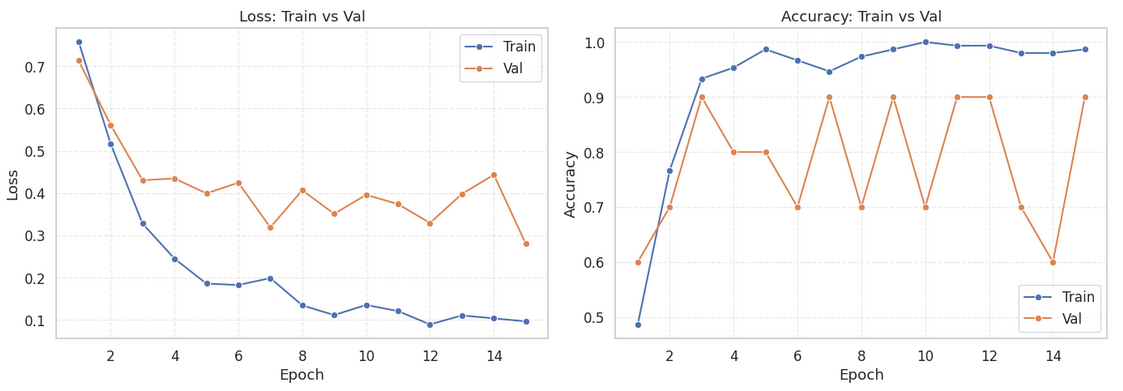
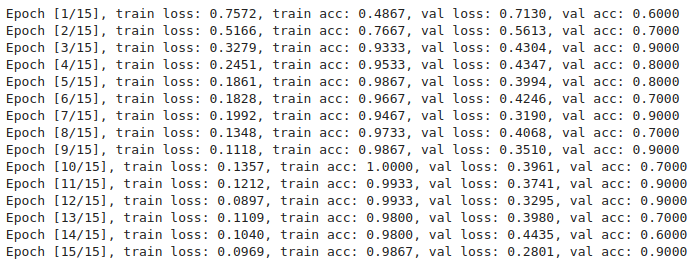